# PSF Experiment 2.0 - Moments + fixnoise

This notebook tests amc vs ngmix with gaussian moments, with or without fixnoise, with or without both shape and pixel noise.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#os
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
#this is us
import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf

#...vs them!
import ngmix
import galsim
from multiprocessing import Pool

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Test Settings

In [4]:
g_psf =  array([0.01,0.0],dtype='float32')
rng = np.random.RandomState(31415)
stamp_size = 51
batch_size = 200
noise_level = 1e-3
psf_noise_level = noise_level/1000
scale = 0.263
ncpus = 48
fixnoise = True
shaped = True
results_folder = "Results/amc_vs_ngmix"
settings_name = "anisotropic_psf_1em3_shaped_fixnoise"

## Get to the Data!

In [5]:
if shaped:
  data = tfds.load('GalGen/small_100k')
else:
  data = tfds.load('simple/small_100k_noshear')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.repeat()
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

## Create observations for ngmix

In [7]:
def observer(batch,shear_true):
  psf_fwhm = 0.7
  psf = galsim.Moffat(beta=4.8, fwhm=psf_fwhm).shear(g1=g_psf[0],g2=g_psf[1])
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method='no_pixel').array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,batch_size,axis=0)

  gal_images =amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([shear_true],
                                        len(onebatch['gal_model']),axis=0))

  noise_img = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  gal_images += noise_img
  psf_noise_img = np.random.normal(scale=psf_noise_level,size=[batch_size,stamp_size,stamp_size])
  psf_images += psf_noise_img
  obslist = []
  for im, psf_im in zip(gal_images,psf_images):
    cen = (np.array(im.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + 0/scale, col=cen[1] + 0/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
    wt = im*0 + 1.0/noise_level**2
    psf_wt = psf_im*0 + 1.0/psf_noise_level**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    obslist += [obs]
  
  return obslist  

## Make the ngmix runner

In [8]:
def ngmix_booter_moments(rng,**kwargs):
  options = {
    'psf': 'dilate',
    'types': ['noshear', 
              '1p', '1m', '2p', '2m', '1p_psf', '1m_psf', '2p_psf', '2m_psf'
              ],
    'scale': scale,
        
  }

  weight_fwhm = 1.2
  fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
  psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

  # these "runners" run the measurement code on observations
  psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
  runner = ngmix.runners.Runner(fitter=fitter)
 
  boot = ngmix.metacal.MetacalBootstrapper(
      runner=runner,
      psf_runner=psf_runner,
      rng=rng,
      psf=options['psf'],
      types=options['types'],
    fixnoise = fixnoise
  )
  return boot

boot = ngmix_booter_moments(rng)

...and run it:

In [9]:
def ngmix_step(obs):
  resdict, _ = boot.go(obs)
  return resdict

## Extract the results

In [10]:
def get_metacal_response_ngmix(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['g'][0], resdict['noshear']['g'][1]])
  g1p = np.array([resdict['1p']['g'][0], resdict['1p']['g'][1]])
  g1m = np.array([resdict['1m']['g'][0], resdict['1m']['g'][1]])
  g2p = np.array([resdict['2p']['g'][0], resdict['2p']['g'][1]])
  g2m = np.array([resdict['2m']['g'][0], resdict['2m']['g'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['g'][0], resdict['1p_psf']['g'][1]])
  g1m_psf = np.array([resdict['1m_psf']['g'][0], resdict['1m_psf']['g'][1]])
  g2p_psf = np.array([resdict['2p_psf']['g'][0], resdict['2p_psf']['g'][1]])
  g2m_psf = np.array([resdict['2m_psf']['g'][0], resdict['2m_psf']['g'][1]])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [11]:
def get_metacal_response_ngmix_moments(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['e'][0], resdict['noshear']['e'][1]])
  g1p = np.array([resdict['1p']['e'][0], resdict['1p']['e'][1]])
  g1m = np.array([resdict['1m']['e'][0], resdict['1m']['e'][1]])
  g2p = np.array([resdict['2p']['e'][0], resdict['2p']['e'][1]])
  g2m = np.array([resdict['2m']['e'][0], resdict['2m']['e'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['e'][0], resdict['1p_psf']['e'][1]])
  g1m_psf = np.array([resdict['1m_psf']['e'][0], resdict['1m_psf']['e'][1]])
  g2p_psf = np.array([resdict['2p_psf']['e'][0], resdict['2p_psf']['e'][1]])
  g2m_psf = np.array([resdict['2m_psf']['e'][0], resdict['2m_psf']['e'][1]])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [12]:
def metacal_shear(e,R):
  return linalg.inv(R) @ e

def metacal_shear_psf(e,R,ep, Rp):
  return linalg.inv(R) @ (e - Rp @ ep)

def bootstraper(x,nboot):
  resample = random.randint(0,len(x),[nboot,len(x)])
  return x[resample].mean(axis=0)
  
def evaluator(ellips, R, g_psf, Rpsf):
  nboot=1000 #bootstraps make it look professional

  #uncorrected  
  resample = random.randint(0,batch_size,[nboot,batch_size])
  e = bootstraper(ellips,nboot).reshape(-1,2,1)
  R = bootstraper(R,nboot)
  Rp = bootstraper(Rpsf,nboot)

  shears = metacal_shear(e,R)
  shear = shears.mean(axis=0)
  shear_err = shears.std(axis=0)

  shearcorrs = metacal_shear_psf(e,R,g_psf.reshape(-1,2,1), Rp)
  shearcorr = shearcorrs.mean(axis=0)
  shearcorr_err = shearcorrs.std(axis=0)
  return shear[...,0], shear_err[...,0],  shearcorr[...,0], shearcorr_err[...,0]

## AutoMetaCal

We will run with a simple moments-based method for now.

In [13]:
def observer_amc(batch,shear_true):
  """makes observations for amc from galaxy models"""
  psf_fwhm = 0.7
  psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=g_psf[0],g2=g_psf[1])
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method='no_pixel').array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,batch_size,axis=0)

  gal_images =amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([shear_true],
                                        len(onebatch['gal_model']),axis=0))

  noise_images = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  gal_images += noise_images
  psf_noise_img = np.random.normal(scale=psf_noise_level,size=[batch_size,stamp_size,stamp_size])
  psf_images += psf_noise_img
  
  return gal_images, psf_images  , noise_images
gal_images, psf_images,noise_images = observer_amc(onebatch,array([0.01,.0],dtype='float32'))

In [23]:
#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=scale, fwhm=1.2)

if fixnoise:
  @tf.function
  def response(gal_images,psf_images,noise_images):
    return amc.metacal_psf_fixnoise.get_metacal_response(gal_images, 
                                                       psf_images,
                                                       psf_images,
                                                       tf.convert_to_tensor(noise_images,dtype=tf.float32),
                                                       method)
else:
  @tf.function
  def response(gal_images,psf_images,noise_images):
    return amc.metacal_psf.get_metacal_response(gal_images, 
                                                       psf_images,
                                                       psf_images,
                                                       method)


In [ ]:
e_amc, e_psf, R_auto, R_psf = response(gal_images, 
                                      psf_images,
                                      tf.convert_to_tensor(noise_images,dtype=tf.float32)
                                      )
                                                                            
shear, shear_err, shearcorr, shearcorr_err= evaluator(e_amc.numpy(), R_auto.numpy() ,e_psf.numpy(), R_psf.numpy())
print('Shakedown test')
print('AutoMetaCal')
print('-------------------------------------------------')
print('With psf correction:')
print(f"shear: {shearcorr[0]:.5f} +/- {shearcorr_err[0]*3:.8f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"shear: {shear[0]:.5f} +/- {shear_err[0]*3:.8f} (99.7%% conf)")

## Batched

In [24]:
shear_range = linspace(-.01,.01,10)

shear_ngmix_list = []
shear_err_ngmix_list = []
shearcorr_ngmix_list = []
shearcorr_err_ngmix_list = []

shear_amc_list = []
shear_err_amc_list = []
shearcorr_amc_list = []
shearcorr_err_amc_list = []

import tqdm
for shear in tqdm.tqdm(shear_range):
  shear_true = array([shear,0.],dtype='float32')  
    
  #batches to fit in memory
  e_ngmix_list = []
  R_ngmix_list = []
  Rpsf_ngmix_list = []
  e_amc_list = []
  e_psf_list = []
  R_amc_list = []
  Rpsf_amc_list = []
  
  for i in range(4):
    onebatch = batchit.next()
    obslist = observer(onebatch,shear_true)

    #print(f"Parallel running ngmix in {ncpus}  processes...")
    pool = Pool(ncpus)
    dlist = pool.map(ngmix_step,obslist)
    pool.close()
    #print("Done!")  

    #REXtractor (REsults eXtractor! :))
    results = [get_metacal_response_ngmix_moments(resdict) for resdict in dlist]
    
    #stack results ngmix
    e_ngmix_list += [result[0]['noshear'] for result in results]
    R_ngmix_list += [result[1] for result in results]
    Rpsf_ngmix_list += [result[2] for result in results]


    #AutoMetaCal
    gal_images, psf_images, noise_images  = observer_amc(onebatch,shear_true)
    e_amc, e_psf, R_auto, R_psf = response(gal_images, psf_images,tf.convert_to_tensor(noise_images,dtype=tf.float32))
    
    #stack results amc
    e_amc_list += [e_amc]
    e_psf_list += [e_psf]
    R_amc_list +=[R_auto]
    Rpsf_amc_list += [R_psf]
  
  e_ngmix = array(e_ngmix_list)
  R_ngmix = array(R_ngmix_list)
  #g_psf = 
  Rpsf_ngmix = array(Rpsf_ngmix_list)
  
  shear_ngmix, shear_err_ngmix, shearcorr_ngmix, shearcorr_err_ngmix= evaluator(e_ngmix, 
                                                                                  R_ngmix,
                                                                                  g_psf, 
                                                                                  Rpsf_ngmix)
  
  e_amc = tf.concat(e_amc_list,axis=0)
  R_amc = tf.concat(R_amc_list,axis=0)
  e_psf =tf.concat(e_psf_list,axis=0)
  Rpsf_amc = tf.concat(Rpsf_amc_list,axis=0)
  
  shear_amc, shear_err_amc, shearcorr_amc, shearcorr_err_amc= evaluator(e_amc.numpy(), 
                                                                          R_amc.numpy() ,
                                                                          g_psf,
                                                                          Rpsf_amc.numpy())
  
  #gather field result  
  shear_ngmix_list += [shear_ngmix]
  shear_err_ngmix_list += [shear_err_ngmix]
  shearcorr_ngmix_list += [shearcorr_ngmix]
  shearcorr_err_ngmix_list += [shearcorr_err_ngmix]

  shear_amc_list += [shear_amc]
  shear_err_amc_list += [shear_err_amc]
  shearcorr_amc_list += [shearcorr_amc]
  shearcorr_err_amc_list += [shearcorr_err_amc]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:37<00:00, 39.77s/it]


## Gather Results

In [25]:
from scipy.stats import linregress

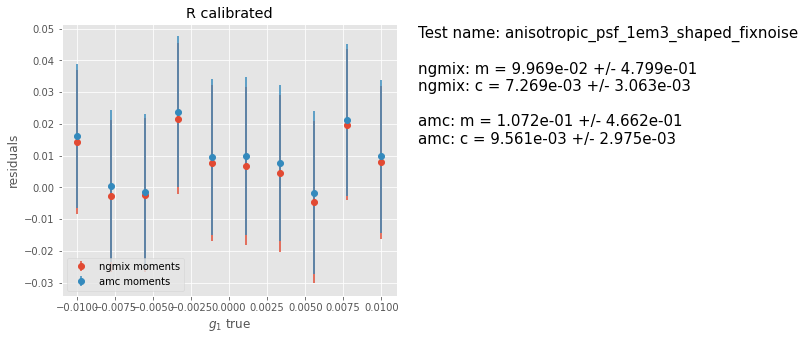

In [26]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shear_ngmix_list)[:,0]
Y1err = array(shear_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = ngmix_bias.slope-1
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"

plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"


errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shear_amc_list)[:,0] 
Y1err = array(shear_err_ngmix_list)[:,0]

#biases
amc_bias = linregress(X1,Y1)
m_amc = amc_bias.slope-1
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calibrated')
savefig(f'{results_folder}/uncorrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

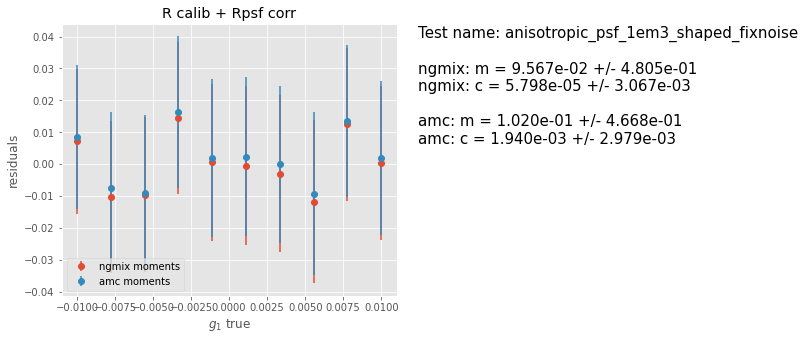

In [27]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shearcorr_ngmix_list)[:,0]
Y1err = array(shearcorr_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = ngmix_bias.slope - 1
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"

plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"


errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shearcorr_amc_list)[:,0] 
Y1err = array(shearcorr_err_ngmix_list)[:,0]


#biases
amc_bias = linregress(X1,Y1)
m_amc = amc_bias.slope-1
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calib + Rpsf corr')
savefig(f'{results_folder}/corrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

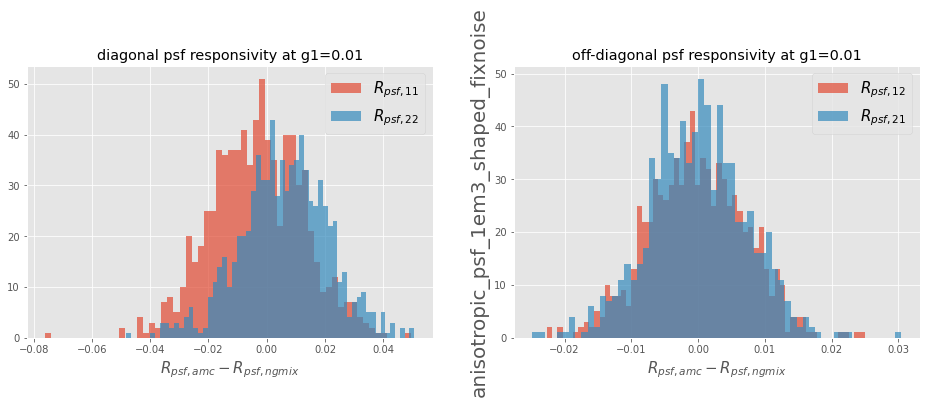

In [28]:
figure(figsize=(16,5))
subplot(121)
hist((Rpsf_amc - Rpsf_ngmix)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,11}$');
hist((Rpsf_amc - Rpsf_ngmix)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,22}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'diagonal psf responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((Rpsf_amc - Rpsf_ngmix)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,12}$');
hist((Rpsf_amc - Rpsf_ngmix)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,21}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'off-diagonal psf responsivity at g1={shear}')
savefig(f'{results_folder}/Rpsf_{settings_name}.jpg',bbox_inches='tight')

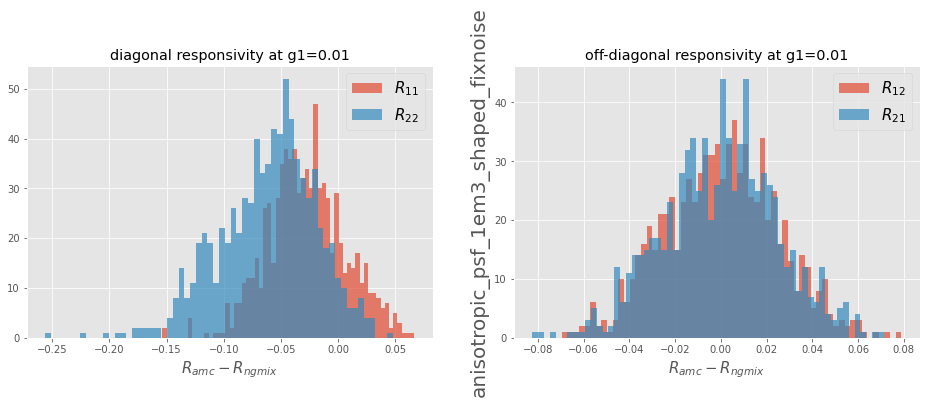

In [29]:
figure(figsize=(16,5))
subplot(121)
hist((R_amc - R_ngmix)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{11}$');
hist((R_amc - R_ngmix)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{22}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'diagonal responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((R_amc - R_ngmix)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{12}$');
hist((R_amc - R_ngmix)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{21}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'off-diagonal responsivity at g1={shear}')
savefig(f'{results_folder}/R_{settings_name}.jpg',bbox_inches='tight')